# Detection - **Poste-processing** of circles

**Content**

- `interpolate`
- `savgol_filter`
- `curve_fit` of `decreasing_func`

Here the idea is that the way in which the size of the ball decreases follows a curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import csv

import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from pathlib import Path

In [20]:
def plot_radius(df):
    plt.figure(figsize=(8,6))
    plt.plot(df['Frame'], df['Radius'], 'o-', label='Radius')
    plt.xlabel('Frame')
    plt.ylabel('Radius')
    plt.title('Radius over frames')
    plt.legend()
    plt.show()

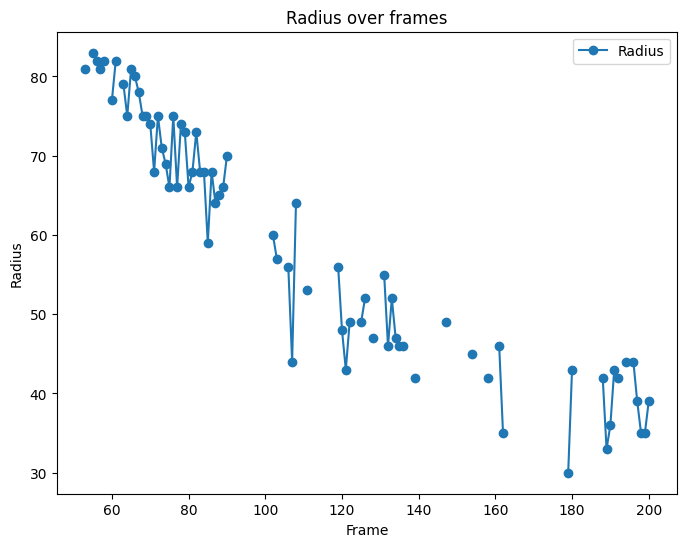

In [21]:
# Example usage
PROJECT_ROOT = Path().resolve().parent.parent
CSV_POSITIONS_FILE_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "circle_positions" / "Circle_positions_2.0_clean.csv")
df = pd.read_csv(CSV_POSITIONS_FILE_PATH)

plot_radius(df)

In [22]:
def decreasing_func(x, a, b, c):
    return a * np.exp(-b * x) + c  # Pure exponential decay function

In [ ]:
def process_radius(df):
    # Ensure all frames are present
    all_frames = pd.DataFrame({'Frame': np.arange(int(df['Frame'].min()), int(df['Frame'].max()) + 1)})
    df = pd.merge(all_frames, df, on='Frame', how='left')  # Merge to keep all frames

    # Interpolate missing radius values
    df['Radius'] = df['Radius'].interpolate(method='linear', limit_direction='both')
    
    # Smooth the radius values
    df['Radius'] = savgol_filter(df['Radius'], window_length=11, polyorder=2, mode='nearest')
    
    # Fit an exponential decreasing function
    popt, _ = curve_fit(decreasing_func, df['Frame'], df['Radius'], p0=(max(df['Radius']), 0.01, min(df['Radius'])), maxfev=10000)
    df['Radius'] = decreasing_func(df['Frame'], *popt)
    
    # Convert radius values to integers
    df['Radius'] = df['Radius'].round().astype(int)
    
    return df

In [24]:
def plot_radius(df, smoothed_df):
    plt.figure(figsize=(8,6))
    plt.plot(df['Frame'], df['Radius'], 'o-', label='Original Radius', alpha=0.5)
    plt.plot(smoothed_df['Frame'], smoothed_df['Radius'], '-', label='Exponential Fit', linewidth=2)
    plt.xlabel('Frame')
    plt.ylabel('Radius')
    plt.title('Radius over frames')
    plt.legend()
    plt.show()

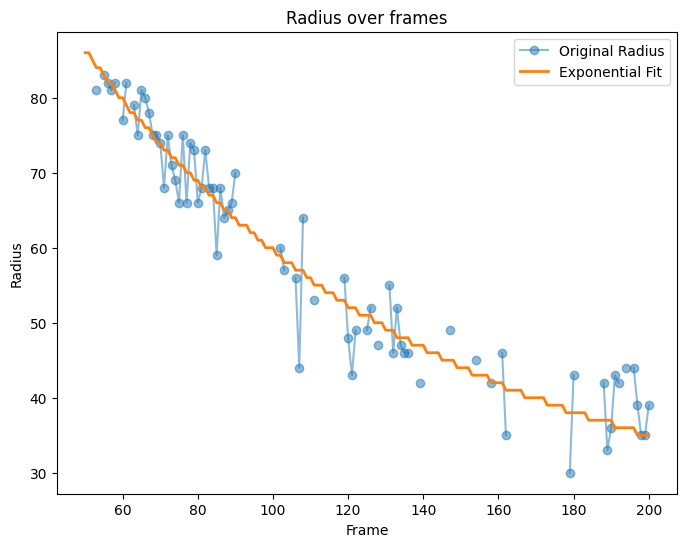

In [25]:
smoothed_df = process_radius(df)
plot_radius(df, smoothed_df)

PROBLEM: here the problem is that if we deal with videos in which I have the zoom, the size of the ball does not follow a curve, so we need to use another approach.

SOLUTION: use filters and interpolations as I have already used in the Post-processing of the centers (less accurate).